In [ ]:
!pip install yfinance xgboost pandas_ta

In [23]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import pandas_ta as ta
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import warnings

# Suppress the warning
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")

# Load financial data
ticker = '^GSPC'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #years
end_date = dt.date.today() + dt.timedelta(days=1)
df = yf.download(ticker, start_date, end_date)

# energy sp500 sector
ticker_energy = '^GSPE'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #years
end_date = dt.date.today() + dt.timedelta(days=1)
df_e = yf.download(ticker_energy, start_date, end_date)

# vix volatibility
ticker_vol = '^VIX'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #years
end_date = dt.date.today() + dt.timedelta(days=1)
df_v = yf.download(ticker_vol, start_date, end_date)

# oil price
ticker_oil = 'CL=F'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #años
end_date = dt.date.today() + dt.timedelta(days=1)
df_oil = yf.download(ticker_oil, start_date, end_date)

# 10 year treasury yield
ticker_dolar = 'DX-Y.NYB'
start_date = dt.date.today() - dt.timedelta(days=365*10)  #años
end_date = dt.date.today() + dt.timedelta(days=1)
df_dolar = yf.download(ticker_dolar, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [24]:
df_oil['Oil_Close'] = df_oil['Close']
df_e['E_Close'] = df_e['Close']
df_v['Vol_Close'] = df_v['Close']
df_dolar['Dolar_Close'] = df_dolar['Close']


In [25]:
# Adding the technical indicators
df['RSI'] = ta.rsi(df['Close'], timeperiod=14)

df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], timeperiod=14)
# Calculate stochastic oscillator
stoch_results = ta.stoch(df['High'], df['Low'], df['Close'], window=14, smooth_window=3)
df['%K'] = stoch_results['STOCHk_14_3_3']
df['%D'] = stoch_results['STOCHd_14_3_3']

# Add the MACD line to df
df_macd=df.ta.macd(fast=12, slow=26, signal=9, append=True)
# Add the MACD line to df
df['MACD'] = df_macd['MACD_12_26_9']

# Calculate On-balance volume
df['OBV']=ta.obv(df['Close'], df['Volume'])

#pct %
df['PCT'] = df['Close'].pct_change()*100



In [26]:
df = pd.concat([df,df_e['E_Close'],df_v['Vol_Close'],df_oil['Oil_Close'],df_dolar['Dolar_Close']], axis=1)
df

,Open,High,Low,Close,Adj Close,Volume,RSI,ATR,%K,%D,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD,OBV,PCT,E_Close,Vol_Close,Oil_Close,Dolar_Close
Date,,,,,,,,,,,,,,,,,,,,
2014-04-22,1872.569946,1884.890015,1872.569946,1879.550049,1879.550049,3.215440e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.215440e+09,NaN,682.049988,13.190000,102.129997,79.910004
2014-04-23,1879.319946,1879.750000,1873.910034,1875.390015,1875.390015,3.085720e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.297200e+08,-0.221331,685.280029,13.270000,101.440002,79.860001
2014-04-24,1881.969971,1884.060059,1870.239990,1878.609985,1878.609985,3.191830e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.321550e+09,0.171696,684.619995,13.320000,101.940002,79.800003
2014-04-25,1877.719971,1877.719971,1859.699951,1863.400024,1863.400024,3.213020e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.085300e+08,-0.809639,681.619995,14.060000,100.599998,79.769997
2014-04-28,1865.000000,1877.010010,1850.609985,1869.430054,1869.430054,4.034680e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.143210e+09,0.323604,683.450012,13.970000,100.839996,79.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-15,5149.669922,5168.430176,5052.470215,5061.819824,5061.819824,3.950210e+09,39.101338,58.288547,20.703105,28.466484,6.643589,-21.399588,28.043178,6.643589,5.387215e+11,-1.202135,728.340027,19.230000,85.410004,106.209999
2024-04-16,5064.589844,5079.839844,5039.830078,5051.410156,5051.410156,4.006200e+09,38.195387,56.982920,6.469277,17.401791,-2.998284,-24.833169,21.834885,-2.998284,5.347153e+11,-0.205651,722.020020,18.400000,85.360001,106.260002
2024-04-17,5068.970215,5077.959961,5007.250000,5022.209961,5022.209961,3.596130e+09,35.696900,57.963423,5.118661,10.763681,-12.847650,-27.746028,14.898378,-12.847650,5.311191e+11,-0.578060,719.559998,18.209999,82.690002,105.949997


In [27]:
df = df.dropna()

# Extract features and signal features
#features = ['Open', 'High','Low', 'Volume', 'RSI','ATR','%K','%D','MACD_12_26_9','MACD','OBV']
#features = ['Open', 'High','Low', 'Volume', 'RSI', 'PCT']
#features = ['Open', 'High','Low', 'Volume', 'RSI','PCT','E_Close','Vol_Close','Oil_Close','Dolar_Close']
features = ['Open', 'High','Low', 'Volume', 'RSI','PCT','E_Close','Vol_Close','Oil_Close']
#features = ['Open', 'High','Low', 'Volume', 'E_Close','Vol_Close','Oil_Close']
x = df[features]
y = df['Close']

In [22]:
x

,Open,High,Low,Volume,RSI,PCT,E_Close,Vol_Close,Oil_Close
Date,,,,,,,,,
2014-06-06,1942.410034,1949.439941,1942.410034,2.864300e+09,76.289082,0.462776,703.130005,10.730000,102.660004
2014-06-09,1948.969971,1955.550049,1947.160034,2.812180e+09,76.782356,0.093877,703.849976,11.150000,104.410004
2014-06-10,1950.339966,1950.859985,1944.640015,2.702360e+09,76.333822,-0.024598,703.140015,10.990000,104.349998
2014-06-11,1949.369995,1949.369995,1940.079956,2.710620e+09,70.002972,-0.353704,705.419983,11.600000,104.400002
2014-06-12,1943.349976,1943.349976,1925.780029,3.040480e+09,59.406462,-0.708889,707.690002,12.560000,106.529999
...,...,...,...,...,...,...,...,...,...
2024-04-12,5171.509766,5175.029785,5107.939941,3.963220e+09,44.960197,-1.455069,734.960022,17.309999,85.660004
2024-04-15,5149.669922,5168.430176,5052.470215,3.950210e+09,39.101338,-1.202135,728.340027,19.230000,85.410004
2024-04-16,5064.589844,5079.839844,5039.830078,4.006200e+09,38.195387,-0.205651,722.020020,18.400000,85.360001


In [28]:
#SCALING THE DATA
scaler = MinMaxScaler(feature_range=(0,1))

x_train = x.reset_index(drop=True)
y_train = y.reset_index(drop=True)

x_train = scaler.fit_transform(x_train)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

y_train = y_train.values.reshape(y_train.shape[0],1)
y_train = scaler.fit_transform(y_train)

print (x_train.shape, y_train.shape)


(2481, 9, 1) (2481, 1)


In [29]:
print(np.min(x_train), np.max(x_train))
print(np.min(y_train), np.max(y_train))

0.0 1.0
0.0 1.0


In [10]:
from keras import layers, Input

model = tf.keras.models.Sequential([
layers.LSTM(units=64,return_sequences=True,input_shape=(x_train.shape[1], 1), activation="swish"),
layers.Dropout(0.2),
layers.LSTM(units=32,return_sequences=True, activation="swish"),
layers.Dropout(0.2),
layers.LSTM(units=16,return_sequences=True, activation="swish"),
layers.Dropout(0.2),
layers.Flatten(),
layers.Dense(16, activation='swish'),
layers.Dense(1)
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 9, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 9, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 9, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,785 (135.88 KB)

 Trainable params: 34,785 (135.88 KB)

 Non-trainable params: 0 (0.00 B)

In [280]:
from keras import layers, Input

model = tf.keras.models.Sequential([
layers.LSTM(units=125,return_sequences=True,input_shape=(x_train.shape[1], 1), activation="swish"),
layers.Dropout(0.2),
layers.LSTM(units=125,return_sequences=True, activation="swish"),
layers.Dropout(0.2),
#layers.LSTM(units=125,return_sequences=True, activation="swish"),
#layers.Dropout(0.2),
layers.Flatten(),
#layers.Dense(16, activation='swish'),
layers.Dense(1)
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_74 (LSTM)                  │ (None, 9, 125)         │        63,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 9, 125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_75 (LSTM)                  │ (None, 9, 125)         │       125,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 9, 125)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 1125)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │         1,126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,126 (742.68 KB)

 Trainable params: 190,126 (742.68 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# BIDIRECTIONAL MODEL
from keras import layers, Input

model = tf.keras.models.Sequential([
layers.Bidirectional(LSTM(units=125,return_sequences=True,input_shape=(x_train.shape[1], 1), activation="swish")),
layers.Dropout(0.2),
layers.Bidirectional(LSTM(units=125,return_sequences=True, activation="swish")),
layers.Dropout(0.2),
layers.Flatten(),
#layers.Dense(16, activation='swish'),
layers.Dense(1, activation="linear")
])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
# OTHER SPLIT DATA MODEL

from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, Lion
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=1e-8)


model.compile(#optimizer=Adam(learning_rate=1e-3),
              optimizer=Lion(learning_rate=1e-3),
              loss="mse",
              metrics=["r2_score"])
model.fit(x_train,y_train,
          epochs=60,
          batch_size=32,
          #verbose=1,
          callbacks=[reduce_lr],
          validation_split=0.2,
          #validation_data=[x_test, y_test]
         )


Epoch 1/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - loss: 0.0408 - r2_score: -0.3967 - val_loss: 0.0021 - val_r2_score: 0.7367 - learning_rate: 0.0010
Epoch 2/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0020 - r2_score: 0.9385 - val_loss: 0.0060 - val_r2_score: 0.2411 - learning_rate: 0.0010
Epoch 3/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7718e-04 - r2_score: 0.9749 - val_loss: 0.0047 - val_r2_score: 0.4071 - learning_rate: 0.0010
Epoch 4/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6221e-04 - r2_score: 0.9791 - val_loss: 0.0018 - val_r2_score: 0.7729 - learning_rate: 0.0010
Epoch 5/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7522e-04 - r2_score: 0.9843 - val_loss: 4.7745e-04 - val_r2_score: 0.9396 - learning_rate: 0.0010
Epoch 6/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0266e-04 - r2_score: 0.9868 - val_loss: 0.0013 - val_r2_score: 0.8369 - learning_rate: 0.0010
Epoch 7/60
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2759e-04 - r2_sc

8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step
(249, 1) (249, 1)
MAPE: 0.006201656116299953
Mean squared error: 1001.3350514867699
Root mean squared error: 31.643878578435512
Mean absolute error: 28.43005812311747
R2: 0.9909222432243882


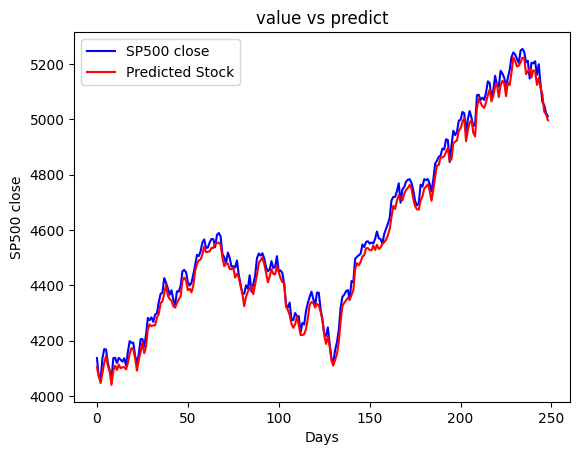

In [32]:
# VALUE VS PREDICTION ONLY WITH VALIDATION DATA

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
# value vs prediction

predicted_stock = model.predict(x_test)
predicted_stock = scaler.inverse_transform(predicted_stock)


sp500_close = scaler.inverse_transform(y_test)

print (predicted_stock.shape, sp500_close.shape)
mape = mean_absolute_percentage_error(sp500_close, predicted_stock)
mse = mean_squared_error(sp500_close, predicted_stock)
rmse = mean_squared_error(sp500_close, predicted_stock, squared=False)
mae = mean_absolute_error(sp500_close, predicted_stock)
r2 = r2_score(sp500_close, predicted_stock)
print("MAPE:", mape)
print("Mean squared error:", mse)
print("Root mean squared error:", rmse)
print("Mean absolute error:", mae)
print("R2:", r2)


plt.plot(sp500_close, color = 'blue', label = 'SP500 close')
plt.plot(predicted_stock, color = 'red', label = 'Predicted Stock')
plt.title('value vs predict')
plt.xlabel('Days')
plt.ylabel('SP500 close')
plt.legend()
plt.show()

In [ ]:
############### XGBOOST ################

In [246]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

#SCALING THE DATA
scaler = MinMaxScaler(feature_range=(0,1))

x_train = x.reset_index(drop=True)
y_train = y.reset_index(drop=True)

x_train = scaler.fit_transform(x_train)

y_train = y_train.values.reshape(y_train.shape[0],1)
y_train = scaler.fit_transform(y_train)


x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)

print (x_train.shape, y_train.shape)

reg = xgb.XGBRegressor(objective='reg:squarederror', booster='gbtree', n_estimators=1000, learning_rate=0.1, max_depth=10, random_state=123)
reg.fit(x_train, y_train, verbose = True)



pred = reg.predict(x_test)


# Calculate RMSE
pred = pred.reshape(pred.shape[0],1)
rmse = mean_squared_error(y_test, pred, squared=False)
print('Root Mean Squared Error:', rmse)

print (y_test.shape, pred.shape)

(1736, 9) (1736, 1)
Root Mean Squared Error: 0.11022366352704863
(745, 1) (745, 1)


In [573]:
print (np.sqrt(np.mean((pred - y_test) ** 2)))

362.86643629406166


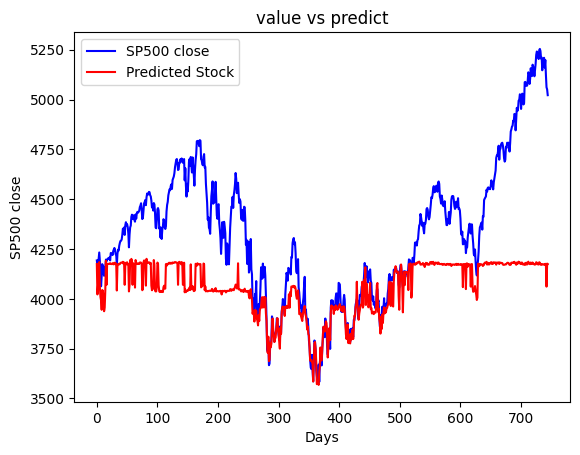

In [247]:
#pred = scaler.inverse_transform(pred)

#sp500_close_xgb = scaler.inverse_transform(y_train)
pred = pred.reshape(pred.shape[0],1)
pred = scaler.inverse_transform(pred)

y_test = scaler.inverse_transform(y_test)

plt.plot(y_test, color = 'blue', label = 'SP500 close')
plt.plot(pred, color = 'red', label = 'Predicted Stock')
plt.title('value vs predict')
plt.xlabel('Days')
plt.ylabel('SP500 close')
plt.legend()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

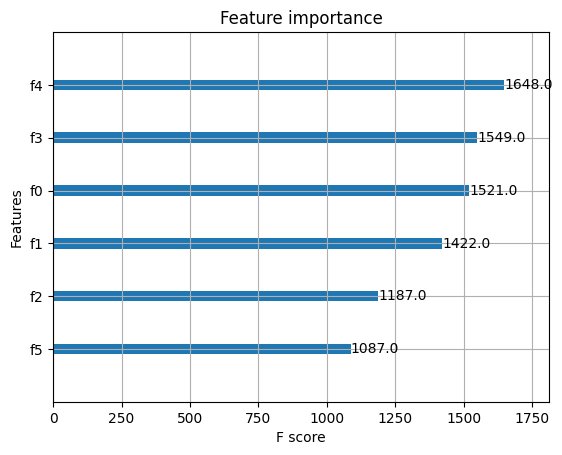

In [579]:
xgb.plot_importance(reg)

In [185]:
print (predicted_stock.shape, sp500_close.shape)

(2483, 1) (2483, 1)
